## Use stacked images (3D) and Densenet121 3D model

Acknowledgements:

- https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
- https://www.kaggle.com/davidbroberts/determining-dicom-image-order
- https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling
- https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train
- https://github.com/shijianjian/EfficientNet-PyTorch-3D

This notebook is based on the implementation of Densenet121 3D available here:
https://www.kaggle.com/mikecho/monai-v060-deep-learning-in-healthcare-imaging

It builds 4 models with only one MRI type, then ensembles all of them computing average probabilities


In [1]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
data_directory = './'
input_monaipath = "/projectnb/ece601/A1-Group5-BrainTumor/MONAI/MONAI-0.7.0/"
monaipath = "monai/"

In [3]:
!mkdir -p {monaipath}
!cp -r {input_monaipath}/* {monaipath}

In [4]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE = 4
N_EPOCHS = 16
SEED = 12345
LEARNING_RATE = 0.0005
LR_DECAY = 0.9

sys.path.append(monaipath)

from monai.networks.nets.densenet import DenseNet121

## Functions to load images

In [5]:
def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.min(data)==np.max(data):
        data = np.zeros((img_size,img_size))
        return data
    
    data = cv2.resize(data, (img_size, img_size))
    return data


def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    files = natural_sort(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"))
    
    every_nth = len(files) / num_imgs
    indexes = [min(int(round(i*every_nth)), len(files)-1) for i in range(0,num_imgs)]
    
    files_to_load = [files[i] for i in indexes]
    
    img3d = np.stack([load_dicom_image(f) for f in files_to_load]).T 
    
    img3d = img3d - np.min(img3d)
    if np.max(img3d) != 0:
        img3d = img3d / np.max(img3d)
    
    return np.expand_dims(img3d,0)


load_dicom_images_3d("00000", mri_type=mri_types[0]).shape

(1, 256, 256, 64)

In [6]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

## train / test splits

In [7]:
samples_to_exclude = [109, 123, 709]

train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
print("original shape", train_df.shape)
train_df = train_df[~train_df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", train_df.shape)
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_df["MGMT_value"],
)


original shape (509, 2)
new shape (507, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
504,1005,1
505,1007,1
506,1008,1
507,1009,0


In [8]:
df_train.tail()

,BraTS21ID,MGMT_value
442,746,1
459,778,0
59,104,0
20,33,1
182,304,1


## Model and training classes

In [9]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type, split=self.split)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type, split="train")
            
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index], dtype=torch.float)}


In [10]:
def build_model():
    model = DenseNet121(spatial_dims=3, in_channels=1, out_channels=1)
    return model    

In [11]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = .0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(valid_loss)
            self.val_auc.append(valid_auc)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            if self.best_valid_score < valid_auc: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_auc, self.lastmodel
                )
                self.best_valid_score = valid_auc
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = torch.tensor(batch["X"]).float().to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets)
                
            loss.backward()

            sum_loss += loss.detach().item()
            
            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch["y"].to(self.device)

                output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)
                loss = self.criterion(output, targets)
                sum_loss += loss.detach().item()
                output = torch.sigmoid(output)

                y_all.extend(batch["y"].tolist())
                outputs_all.extend(output.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

## train models

(405, 2) (102, 2)


,BraTS21ID,MGMT_value
471,797,0
225,380,0
100,169,0
273,457,1
417,703,0


,BraTS21ID,MGMT_value
427,725,1
162,273,1
407,684,0
228,386,1
288,493,1


EPOCH: 1


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 1] loss: 0.7127, time: 80.00 s
[Epoch Valid: 1] loss: 0.8955, auc: 0.5370, time: 24.00 s
auc improved from 0.0000 to 0.5370. Saved model to 'FLAIR-e1-loss0.895-auc0.537.pth'
EPOCH: 2


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 2] loss: 0.7173, time: 70.00 s
[Epoch Valid: 2] loss: 0.6811, auc: 0.6370, time: 9.00 s
auc improved from 0.5370 to 0.6370. Saved model to 'FLAIR-e2-loss0.681-auc0.637.pth'
EPOCH: 3


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 3] loss: 0.7076, time: 70.00 s
[Epoch Valid: 3] loss: 0.7030, auc: 0.5390, time: 9.00 s
EPOCH: 4


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 4] loss: 0.6882, time: 69.00 s
[Epoch Valid: 4] loss: 0.7025, auc: 0.5505, time: 9.00 s
EPOCH: 5


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 5] loss: 0.6936, time: 71.00 s
[Epoch Valid: 5] loss: 0.7320, auc: 0.5216, time: 9.00 s
EPOCH: 6


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 6] loss: 0.6918, time: 69.00 s
[Epoch Valid: 6] loss: 0.7232, auc: 0.5486, time: 9.00 s
EPOCH: 7


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 7] loss: 0.6851, time: 69.00 s
[Epoch Valid: 7] loss: 0.7310, auc: 0.5262, time: 9.00 s
EPOCH: 8


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 8] loss: 0.6989, time: 69.00 s
[Epoch Valid: 8] loss: 0.6876, auc: 0.5386, time: 9.00 s
EPOCH: 9


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 9] loss: 0.6804, time: 73.00 s
[Epoch Valid: 9] loss: 0.7033, auc: 0.5100, time: 9.00 s
EPOCH: 10


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 10] loss: 0.6761, time: 72.00 s
[Epoch Valid: 10] loss: 0.6853, auc: 0.5687, time: 9.00 s
EPOCH: 11


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 11] loss: 0.6792, time: 71.00 s
[Epoch Valid: 11] loss: 0.7121, auc: 0.5586, time: 9.00 s
EPOCH: 12


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 12] loss: 0.6740, time: 71.00 s
[Epoch Valid: 12] loss: 0.6882, auc: 0.5552, time: 9.00 s
EPOCH: 13


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 13] loss: 0.6735, time: 71.00 s
[Epoch Valid: 13] loss: 0.6967, auc: 0.5293, time: 9.00 s
EPOCH: 14


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 14] loss: 0.6724, time: 73.00 s
[Epoch Valid: 14] loss: 0.7237, auc: 0.5428, time: 10.00 s
EPOCH: 15


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 15] loss: 0.6823, time: 73.00 s
[Epoch Valid: 15] loss: 0.6842, auc: 0.5783, time: 9.00 s
EPOCH: 16


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 16] loss: 0.6636, time: 71.00 s
[Epoch Valid: 16] loss: 0.6921, auc: 0.5760, time: 9.00 s


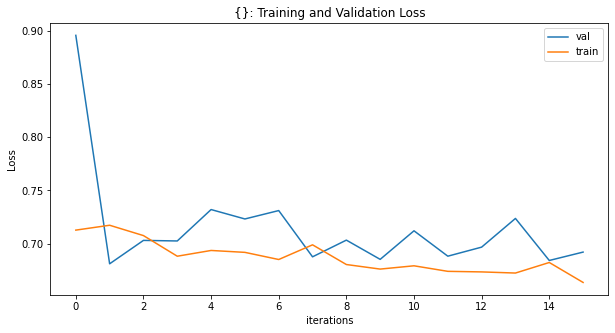

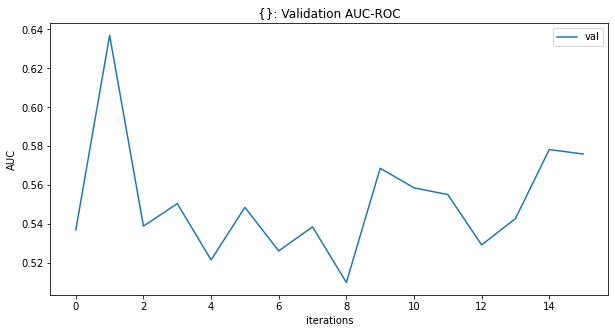

(405, 2) (102, 2)


,BraTS21ID,MGMT_value
471,797,0
225,380,0
100,169,0
273,457,1
417,703,0


,BraTS21ID,MGMT_value
427,725,1
162,273,1
407,684,0
228,386,1
288,493,1


EPOCH: 1


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 1] loss: 0.7289, time: 73.00 s
[Epoch Valid: 1] loss: 0.7356, auc: 0.3715, time: 20.00 s
auc improved from 0.0000 to 0.3715. Saved model to 'T1w-e1-loss0.736-auc0.372.pth'
EPOCH: 2


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 2] loss: 0.7065, time: 70.00 s
[Epoch Valid: 2] loss: 0.6947, auc: 0.6003, time: 8.00 s
auc improved from 0.3715 to 0.6003. Saved model to 'T1w-e2-loss0.695-auc0.600.pth'
EPOCH: 3


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 3] loss: 0.7206, time: 70.00 s
[Epoch Valid: 3] loss: 0.7010, auc: 0.6339, time: 9.00 s
auc improved from 0.6003 to 0.6339. Saved model to 'T1w-e3-loss0.701-auc0.634.pth'
EPOCH: 4


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 4] loss: 0.6964, time: 70.00 s
[Epoch Valid: 4] loss: 0.7377, auc: 0.4576, time: 8.00 s
EPOCH: 5


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 5] loss: 0.7074, time: 70.00 s
[Epoch Valid: 5] loss: 0.7005, auc: 0.4985, time: 9.00 s
EPOCH: 6


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 6] loss: 0.6942, time: 70.00 s
[Epoch Valid: 6] loss: 0.6963, auc: 0.5127, time: 9.00 s
EPOCH: 7


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 7] loss: 0.6927, time: 69.00 s
[Epoch Valid: 7] loss: 0.6785, auc: 0.6478, time: 8.00 s
auc improved from 0.6339 to 0.6478. Saved model to 'T1w-e7-loss0.678-auc0.648.pth'
EPOCH: 8


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 8] loss: 0.6971, time: 70.00 s
[Epoch Valid: 8] loss: 0.6983, auc: 0.4942, time: 9.00 s
EPOCH: 9


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 9] loss: 0.6934, time: 69.00 s
[Epoch Valid: 9] loss: 0.7107, auc: 0.5012, time: 8.00 s
EPOCH: 10


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 10] loss: 0.6881, time: 69.00 s
[Epoch Valid: 10] loss: 0.7103, auc: 0.5127, time: 9.00 s
EPOCH: 11


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 11] loss: 0.6855, time: 69.00 s
[Epoch Valid: 11] loss: 0.7229, auc: 0.5143, time: 9.00 s
EPOCH: 12


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 12] loss: 0.6777, time: 69.00 s
[Epoch Valid: 12] loss: 0.7738, auc: 0.4560, time: 9.00 s
EPOCH: 13


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 13] loss: 0.6864, time: 69.00 s
[Epoch Valid: 13] loss: 0.7158, auc: 0.4981, time: 9.00 s
EPOCH: 14


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 14] loss: 0.6834, time: 70.00 s
[Epoch Valid: 14] loss: 0.7020, auc: 0.5382, time: 9.00 s
EPOCH: 15


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 15] loss: 0.6730, time: 70.00 s
[Epoch Valid: 15] loss: 0.7238, auc: 0.5783, time: 9.00 s
EPOCH: 16


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 16] loss: 0.6730, time: 69.00 s
[Epoch Valid: 16] loss: 0.7266, auc: 0.5463, time: 8.00 s


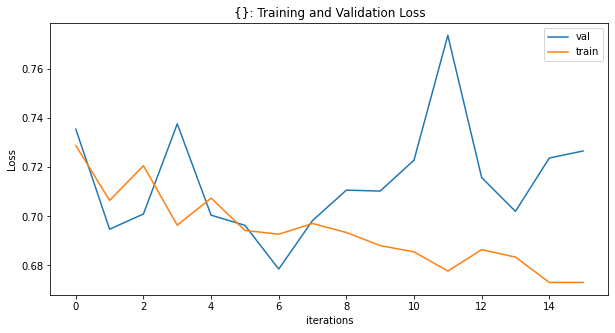

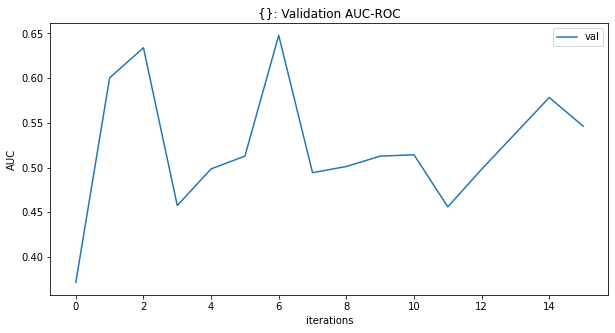

(405, 2) (102, 2)


,BraTS21ID,MGMT_value
471,797,0
225,380,0
100,169,0
273,457,1
417,703,0


,BraTS21ID,MGMT_value
427,725,1
162,273,1
407,684,0
228,386,1
288,493,1


EPOCH: 1


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 1] loss: 0.7237, time: 78.00 s
[Epoch Valid: 1] loss: 0.6900, auc: 0.5914, time: 23.00 s
auc improved from 0.0000 to 0.5914. Saved model to 'T1wCE-e1-loss0.690-auc0.591.pth'
EPOCH: 2


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 2] loss: 0.7041, time: 69.00 s
[Epoch Valid: 2] loss: 0.6860, auc: 0.6138, time: 8.00 s
auc improved from 0.5914 to 0.6138. Saved model to 'T1wCE-e2-loss0.686-auc0.614.pth'
EPOCH: 3


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 3] loss: 0.6946, time: 69.00 s
[Epoch Valid: 3] loss: 0.6813, auc: 0.5945, time: 9.00 s
EPOCH: 4


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 4] loss: 0.7020, time: 69.00 s
[Epoch Valid: 4] loss: 0.6831, auc: 0.5791, time: 8.00 s
EPOCH: 5


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 5] loss: 0.6913, time: 69.00 s
[Epoch Valid: 5] loss: 0.6866, auc: 0.5787, time: 9.00 s
EPOCH: 6


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 6] loss: 0.6967, time: 70.00 s
[Epoch Valid: 6] loss: 0.6845, auc: 0.5787, time: 9.00 s
EPOCH: 7


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 7] loss: 0.6900, time: 70.00 s
[Epoch Valid: 7] loss: 0.6777, auc: 0.6119, time: 9.00 s
EPOCH: 8


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 8] loss: 0.6919, time: 70.00 s
[Epoch Valid: 8] loss: 0.6968, auc: 0.6049, time: 9.00 s
EPOCH: 9


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 9] loss: 0.6855, time: 70.00 s
[Epoch Valid: 9] loss: 0.6876, auc: 0.5822, time: 8.00 s
EPOCH: 10


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 10] loss: 0.6954, time: 69.00 s
[Epoch Valid: 10] loss: 0.6882, auc: 0.5860, time: 9.00 s
EPOCH: 11


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 11] loss: 0.6771, time: 70.00 s
[Epoch Valid: 11] loss: 0.6903, auc: 0.6107, time: 9.00 s
EPOCH: 12


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 12] loss: 0.6854, time: 70.00 s
[Epoch Valid: 12] loss: 0.6968, auc: 0.5721, time: 9.00 s
EPOCH: 13


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 13] loss: 0.6791, time: 70.00 s
[Epoch Valid: 13] loss: 0.6734, auc: 0.6026, time: 9.00 s
EPOCH: 14


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 14] loss: 0.6777, time: 70.00 s
[Epoch Valid: 14] loss: 0.8529, auc: 0.5054, time: 9.00 s
EPOCH: 15


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 15] loss: 0.6832, time: 70.00 s
[Epoch Valid: 15] loss: 0.7075, auc: 0.5664, time: 9.00 s
EPOCH: 16


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 16] loss: 0.6620, time: 70.00 s
[Epoch Valid: 16] loss: 0.6782, auc: 0.6034, time: 9.00 s


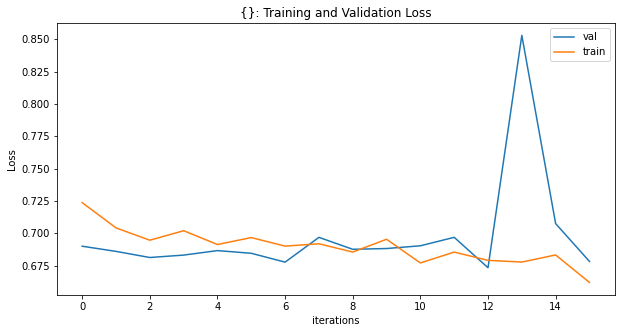

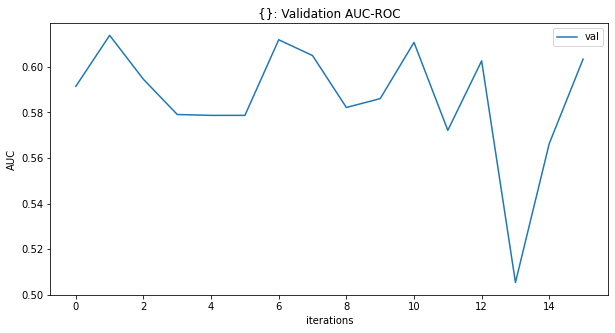

(405, 2) (102, 2)


,BraTS21ID,MGMT_value
471,797,0
225,380,0
100,169,0
273,457,1
417,703,0


,BraTS21ID,MGMT_value
427,725,1
162,273,1
407,684,0
228,386,1
288,493,1


EPOCH: 1


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 1] loss: 0.7246, time: 76.00 s
[Epoch Valid: 1] loss: 0.6977, auc: 0.5613, time: 20.00 s
auc improved from 0.0000 to 0.5613. Saved model to 'T2w-e1-loss0.698-auc0.561.pth'
EPOCH: 2


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 2] loss: 0.7140, time: 70.00 s
[Epoch Valid: 2] loss: 0.6960, auc: 0.4745, time: 9.00 s
EPOCH: 3


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 3] loss: 0.6984, time: 70.00 s
[Epoch Valid: 3] loss: 0.6777, auc: 0.6470, time: 9.00 s
auc improved from 0.5613 to 0.6470. Saved model to 'T2w-e3-loss0.678-auc0.647.pth'
EPOCH: 4


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 4] loss: 0.6977, time: 70.00 s
[Epoch Valid: 4] loss: 0.6635, auc: 0.6485, time: 9.00 s
auc improved from 0.6470 to 0.6485. Saved model to 'T2w-e4-loss0.663-auc0.649.pth'
EPOCH: 5


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 5] loss: 0.6924, time: 70.00 s
[Epoch Valid: 5] loss: 0.7710, auc: 0.3356, time: 9.00 s
EPOCH: 6


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 6] loss: 0.6953, time: 70.00 s
[Epoch Valid: 6] loss: 0.8349, auc: 0.3468, time: 9.00 s
EPOCH: 7


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 7] loss: 0.6936, time: 70.00 s
[Epoch Valid: 7] loss: 0.6797, auc: 0.6354, time: 9.00 s
EPOCH: 8


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 8] loss: 0.6851, time: 70.00 s
[Epoch Valid: 8] loss: 0.6796, auc: 0.5810, time: 9.00 s
EPOCH: 9


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 9] loss: 0.6822, time: 70.00 s
[Epoch Valid: 9] loss: 0.7265, auc: 0.3985, time: 9.00 s
EPOCH: 10


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 10] loss: 0.6888, time: 70.00 s
[Epoch Valid: 10] loss: 0.6803, auc: 0.5702, time: 9.00 s
EPOCH: 11


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 11] loss: 0.6800, time: 70.00 s
[Epoch Valid: 11] loss: 0.7515, auc: 0.3692, time: 9.00 s
EPOCH: 12


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 12] loss: 0.6793, time: 70.00 s
[Epoch Valid: 12] loss: 0.7565, auc: 0.3773, time: 9.00 s
EPOCH: 13


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 13] loss: 0.6906, time: 70.00 s
[Epoch Valid: 13] loss: 0.6811, auc: 0.5741, time: 9.00 s
EPOCH: 14


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 14] loss: 0.6775, time: 70.00 s
[Epoch Valid: 14] loss: 0.7000, auc: 0.5193, time: 9.00 s
EPOCH: 15


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 15] loss: 0.6764, time: 70.00 s
[Epoch Valid: 15] loss: 0.7333, auc: 0.4217, time: 9.00 s
EPOCH: 16


<ipython-input-11-edbcef4c9c66>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch["X"]).float().to(self.device)


<ipython-input-11-edbcef4c9c66>:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = self.model(torch.tensor(batch["X"]).float().to(self.device)).squeeze(1)


[Epoch Train: 16] loss: 0.6632, time: 70.00 s
[Epoch Valid: 16] loss: 0.7489, auc: 0.4182, time: 9.00 s


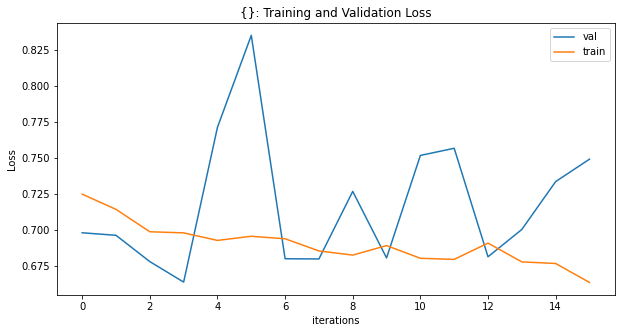

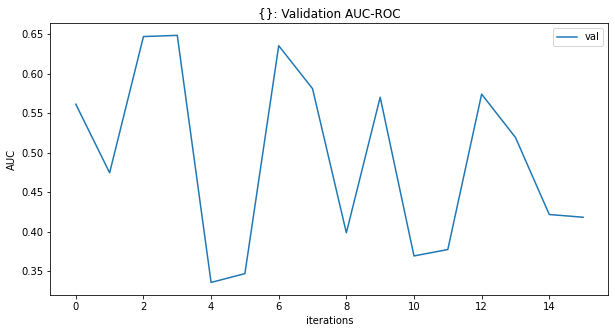

['FLAIR-e2-loss0.681-auc0.637.pth', 'T1w-e7-loss0.678-auc0.648.pth', 'T1wCE-e2-loss0.686-auc0.614.pth', 'T2w-e4-loss0.663-auc0.649.pth']


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    display(df_valid.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        mri_type
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        mri_type
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=8,
    )

    model = build_model()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        N_EPOCHS, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        N_EPOCHS,
    )
    
    trainer.display_plots(mri_type)
    
    return trainer.lastmodel

modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

# Prediction

In [13]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    data_retriever = Dataset(
        df.index.values, 
        mri_type=mri_type,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = build_model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(torch.tensor(batch["X"]).float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

**Validation**

Predict: FLAIR-e2-loss0.681-auc0.637.pth FLAIR (102, 2)


<ipython-input-13-8637b85b1f78>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp_pred = torch.sigmoid(model(torch.tensor(batch["X"]).float().to(device)).squeeze(1)).cpu().numpy().squeeze()


Predict: T1w-e7-loss0.678-auc0.648.pth T1w (102, 2)
Predict: T1wCE-e2-loss0.686-auc0.614.pth T1wCE (102, 2)
Predict: T2w-e4-loss0.663-auc0.649.pth T2w (102, 2)
Validation ensemble AUC: 0.6532


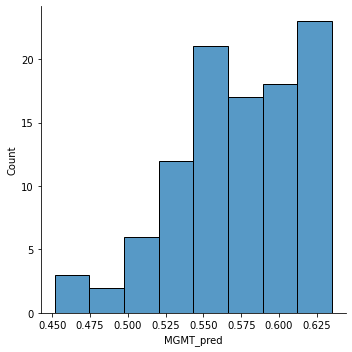

In [14]:
df_pred = df_valid.set_index("BraTS21ID")
df_pred["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_pred, mtype, "train")
    df_pred["MGMT_pred"] += pred["MGMT_value"]
df_pred["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_pred["MGMT_value"], df_pred["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_pred["MGMT_pred"])

**Submission**

In [15]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv", index_col="BraTS21ID")

submission["MGMT_value"] = 0
for m, mtype in zip(modelfiles, mri_types):
    pred = predict(m, submission, mtype, split="test")
    submission["MGMT_value"] += pred["MGMT_value"]

submission["MGMT_value"] /= len(modelfiles)
submission["MGMT_value"].to_csv("TT_Model4_DenseNet.csv")

Predict: FLAIR-e2-loss0.681-auc0.637.pth FLAIR (76, 1)


<ipython-input-13-8637b85b1f78>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tmp_pred = torch.sigmoid(model(torch.tensor(batch["X"]).float().to(device)).squeeze(1)).cpu().numpy().squeeze()


Predict: T1w-e7-loss0.678-auc0.648.pth T1w (76, 1)
Predict: T1wCE-e2-loss0.686-auc0.614.pth T1wCE (76, 1)
Predict: T2w-e4-loss0.663-auc0.649.pth T2w (76, 1)
